In [4]:
import warnings
warnings.filterwarnings('ignore')
#Data Manipulation and Treatment
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt

#Plotting and Visualizations
import matplotlib.pyplot as plt

#Statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima import auto_arima

In [5]:
#Download stock data
df = yf.download('aapl', start='2010-01-01', end='2020-01-01')
df = df.resample('D').asfreq()
df = df.ffill()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600.0
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526478,601904800.0
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000.0
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410789,477131200.0
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800.0


Text(0.5, 1.0, 'Apple Closing Price')

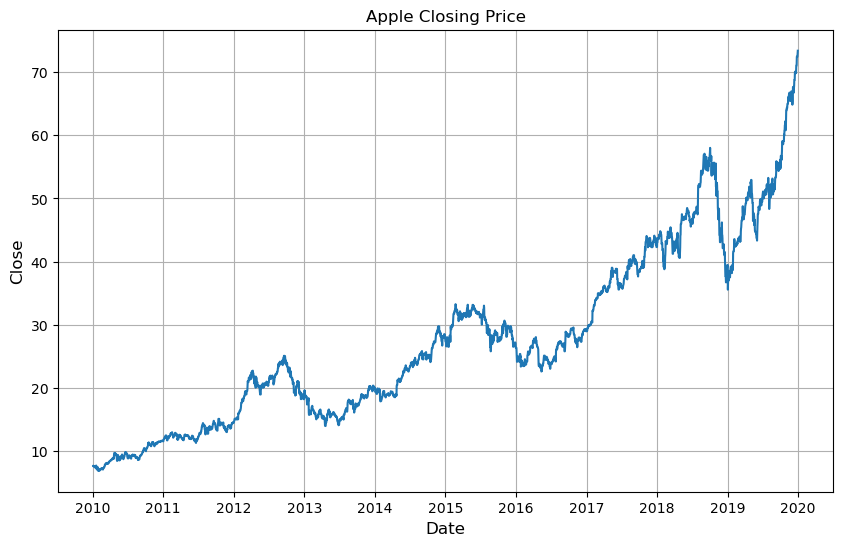

In [6]:
#Plot closing price of stock data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df["Close"], label='Original')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.title('Apple Closing Price')

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

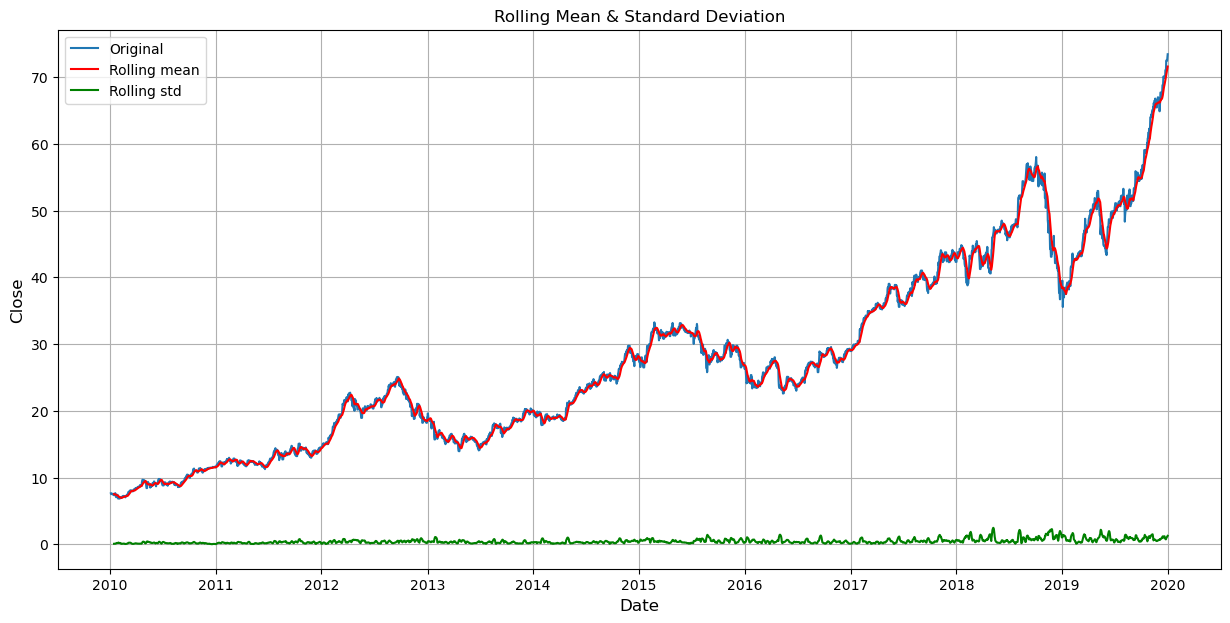

In [7]:
# Checking Trend and Seasonality
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(df["Close"], label='Original')
plt.plot(df["Close"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Close"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

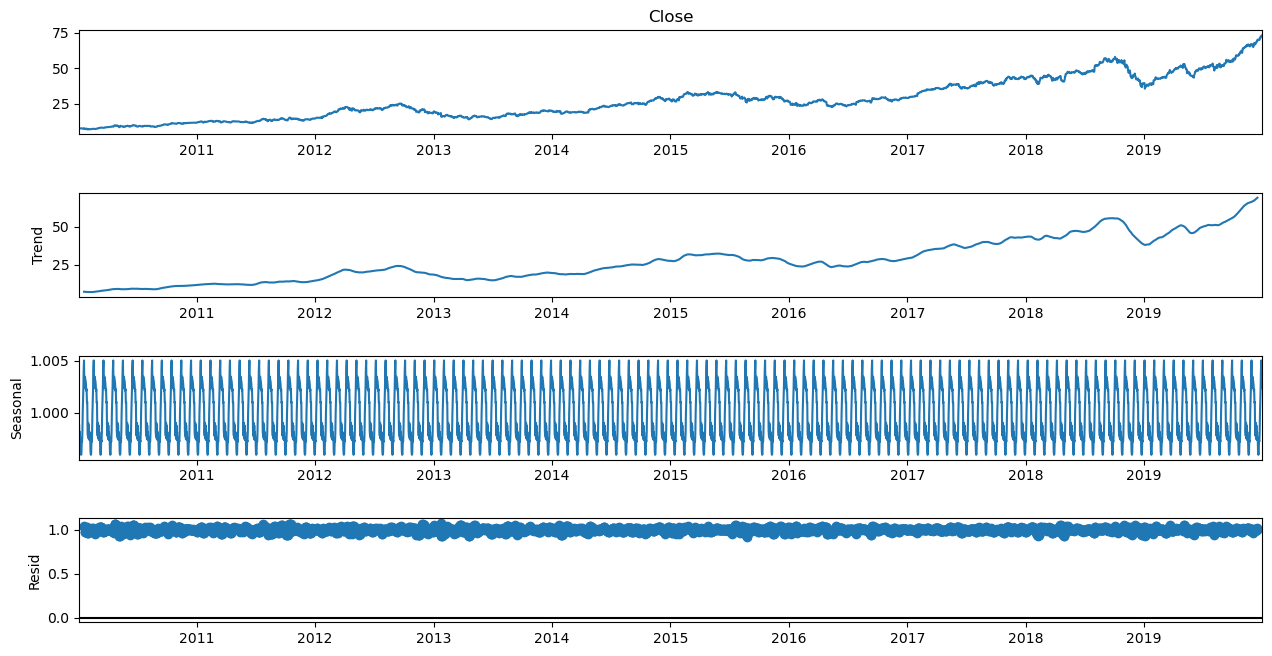

In [8]:
# Checking Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
    
fig = decomposition.plot()
fig.set_size_inches(14, 7)

In [9]:
#Running ADF Test on raw data
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    if dftest[1] > 0.05:
        print('Cannot reject the Null Hypothesis: Data not stationary.')
    else:
        print('Reject the Null Hypothesis: Data is stationary.')
ADF_test(df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                    0.929703
p-value                           0.993466
Lags Used                        30.000000
Number of Observations Used    3618.000000
Critical Value (1%)              -3.432159
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64
Cannot reject the Null Hypothesis: Data not stationary.


Text(0.5, 1.0, 'Apple Closing Price')

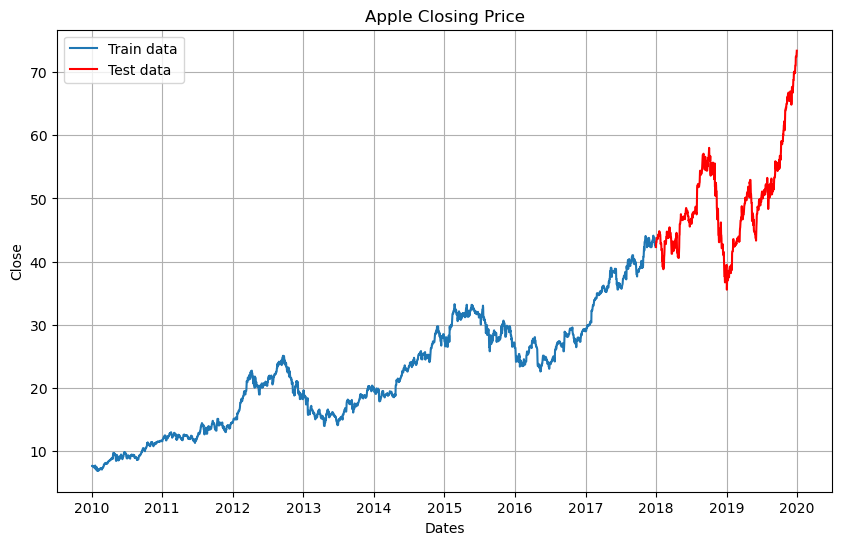

In [10]:
#Split data into train and training set
df_train, df_test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]

#Plot split data
y_pred=df_test.copy()
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df_train['Close'], label='Train data')
plt.plot(df_test['Close'], 'red', label='Test data')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.legend()
plt.title('Apple Closing Price')

Text(0.5, 1.0, 'First Order Differencing')

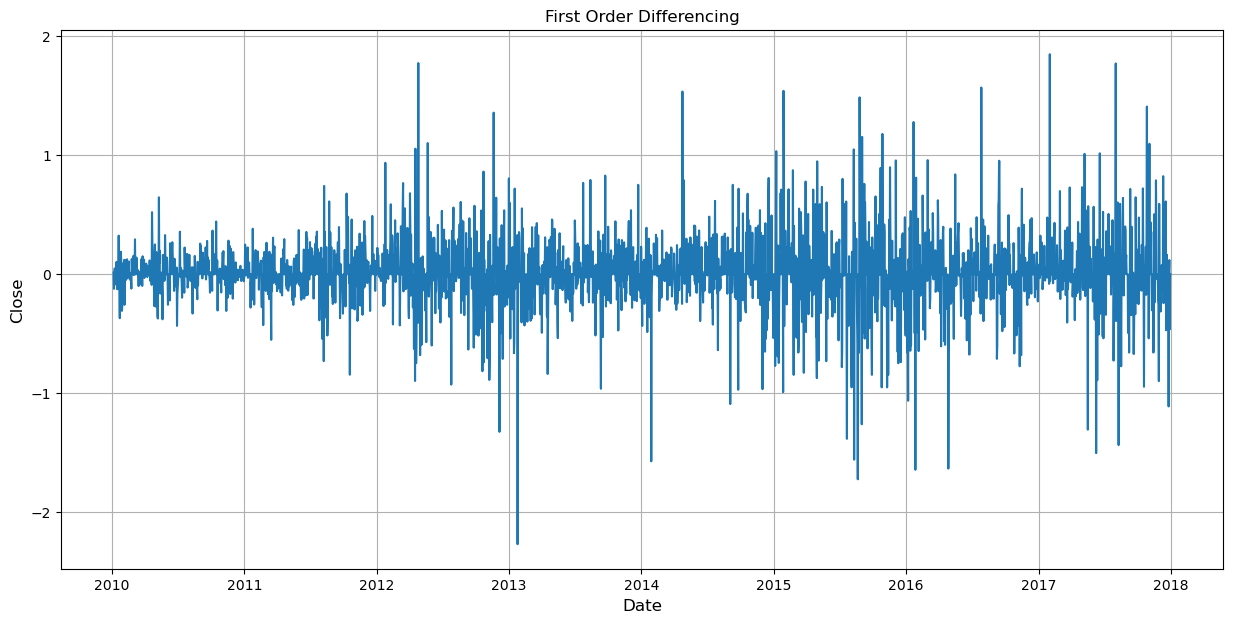

In [11]:
#Apply first order differencing to data
df_train_diff = df_train['Close'].diff().dropna()

#Plot differenced data
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(df_train_diff, label='Original')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.title('First Order Differencing')

In [12]:
#Perform ADF test on differenced data
ADF_test(df_train_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -24.754714
p-value                           0.000000
Lags Used                         4.000000
Number of Observations Used    2913.000000
Critical Value (1%)              -3.432597
Critical Value (5%)              -2.862533
Critical Value (10%)             -2.567298
dtype: float64
Reject the Null Hypothesis: Data is stationary.


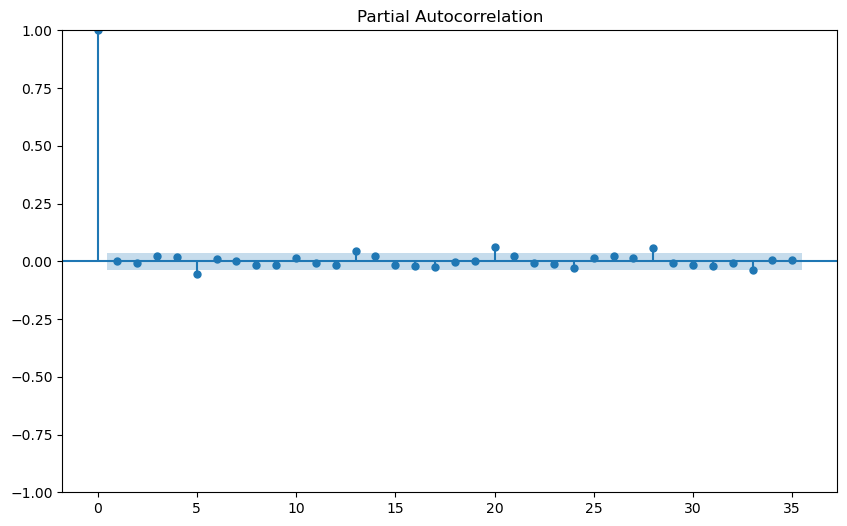

In [13]:
#Plot PACF
plt.rc("figure", figsize=(10,6))
pacf = plot_pacf(df_train_diff)

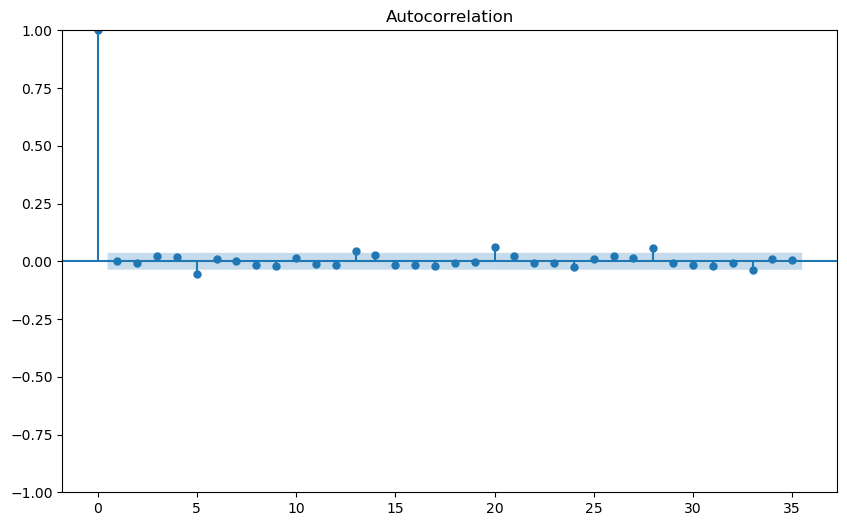

In [14]:
#Plot ACF
acf = plot_acf(df_train_diff)

In [15]:
#Fit ARIMA model to data
model_arima= auto_arima(df_train['Close'],trace=True, 
                        error_action='ignore', 
                        start_p=1,
                        start_q=1,
                        max_p=5,
                        max_q=5,
                        suppress_warnings=True,
                        stepwise=False,
                        seasonal=False)
model_arima.fit(df_train['Close'])


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1022.487, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1024.462, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1026.317, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1026.714, Time=0.44 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1027.500, Time=0.70 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1021.288, Time=0.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1024.463, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1026.463, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1028.439, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1028.499, Time=1.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1025.087, Time=1.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1026.318, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1028.129, Time=1.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1018.232, Time=1.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1018.501, Time=2.37 sec
 ARIMA(3,1

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

Text(0.5, 1.0, 'ARIMA(2,1,2) Model Results')

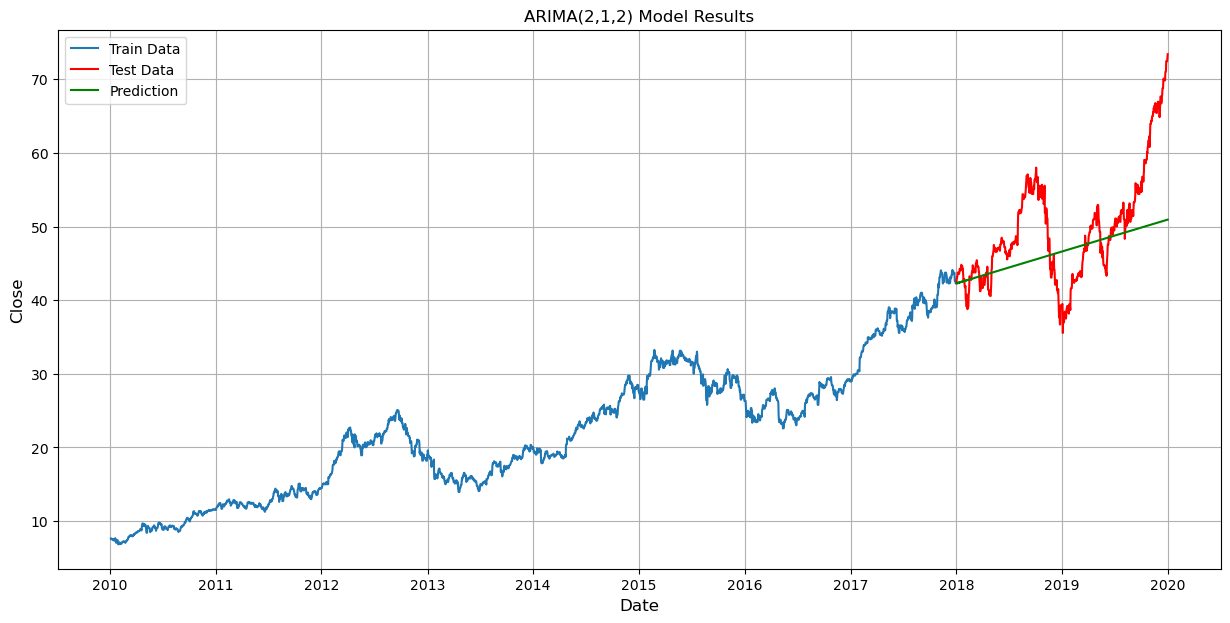

In [16]:
#Use model to make predictions on test data
prediction_arima=model_arima.predict(len(df_test))
y_pred["ARIMA Model Prediction"]=prediction_arima.dropna()

#Plot results
plt.figure(figsize=(15,7))
plt.plot(df_train["Close"], label='Train Data')
plt.plot(df_test["Close"], color='red', label='Test Data')
plt.plot(y_pred["ARIMA Model Prediction"], color='green', label='Prediction')
plt.grid(True)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.title('ARIMA(2,1,2) Model Results')

Text(0.5, 1.0, 'ARIMA(2,1,2) Model Results')

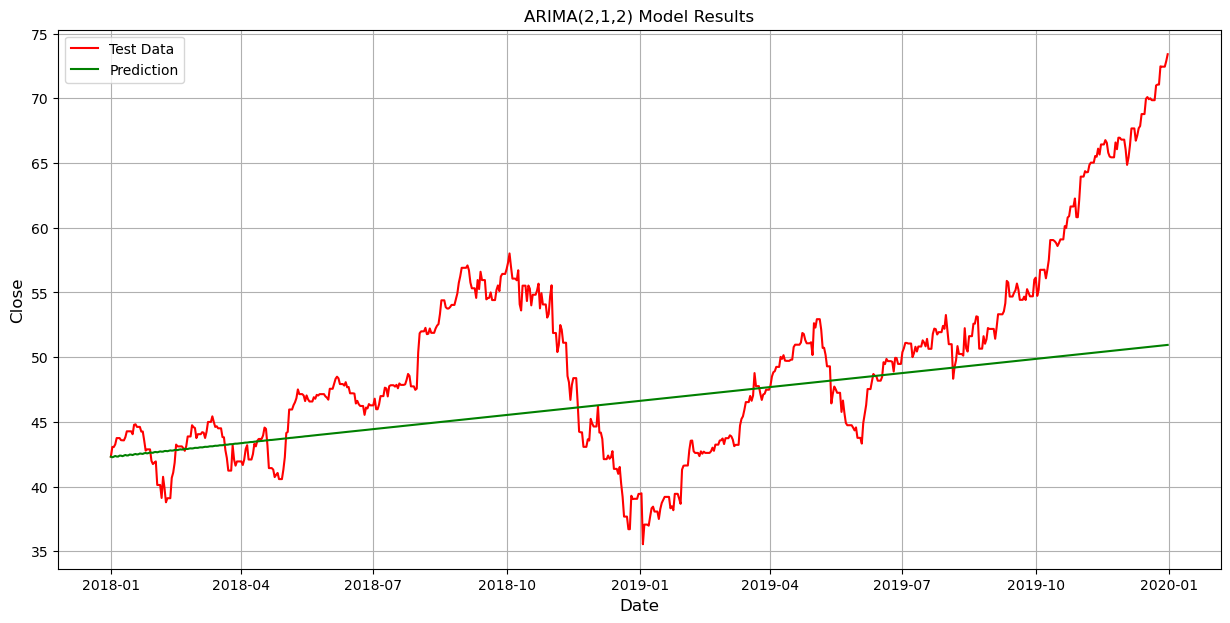

In [17]:
#Plot Results
plt.figure(figsize=(15,7))
plt.plot(df_test["Close"], color='red', label='Test Data')
plt.plot(y_pred["ARIMA Model Prediction"], color='green', label='Prediction')
plt.grid(True)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.title('ARIMA(2,1,2) Model Results')

In [18]:
#Calculate Mean Squared Error and Mean Absolute Percentage Error
mse_arima= mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
mape_arima=mean_absolute_percentage_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
print("Mean Square Error ARIMA: ",mse_arima)
print("Mean Absoulute Percentage Error ARIMA: ",mape_arima)

Mean Square Error ARIMA:  48.852635703072664
Mean Absoulute Percentage Error ARIMA:  0.09749566177893419
